# Preserving the structural similarity index for floating-point data (dSSIM) with safeguards

In this example, we compare the structural similarity index for floating-point data (dSSIM) [^1] after compressing a dataset of `u` wind with three different lossy compressors (ZFP, SZ3, SPERR). We then stress-test the quantity of interest (QoI) implementation of the safeguards by preserving an error bound on the dSSIM by translating the dSSIM computation into a quantity of interest, which involves rescaling and linearly quantizing values, applying a 2D Gaussian smoothing kernel, and computing variances and co-variances.

[^1]: Baker, A. H., Pinard, A. and Hammerling, D. M. (2024). On a Structural Similarity Index Approach for Floating-Point Data. *IEEE Transactions on Visualization and Computer Graphics*. 30(9), 6261-6274. Available from: [doi:10.1109/TVCG.2023.3332843](https://doi.org/10.1109/TVCG.2023.3332843).

In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
import time
from collections import defaultdict
from pathlib import Path

import earthkit.plots
import numpy as np
import xarray as xr
from astropy.convolution import Gaussian2DKernel, convolve

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-uv" / "data.nc")
ERA5_U = ERA5["u"].sel(valid_time="2024-04-02T12:00:00", pressure_level=500)

In [4]:
ERA5_U.shape

(721, 1440)

In [5]:
def dssim_mat(
    a1: np.ndarray,
    a2: np.ndarray,
    eps: float = 1e-8,
    kernel_size: int = 11,
) -> np.ndarray:
    """
    Implementation adapted from the official dSSIM implementation at
    https://github.com/NCAR/ldcpy/blob/6c5bcb8149ec7876a4f53b0e784e9c528f6f14cb/ldcpy/calcs.py#L2516

    The official implementation makes assumptions about the input data that are
    specific to models developed at NCAR which is why we cannot use the official
    implementation directly.

    Parameters
    ----------
    x : np.ndarray
        Shape: (latitude, longitude)
    y : np.ndarray
        Shape: (latitude, longitude)
    kernel_size : int
        The size of the Gaussian kernel for the convolution operation in SSIM. Has to be
        an odd number. The default is 11.

    Returns
    -------
    dssim : np.ndarray
        The pointwise data-SSIM values where the k x k kernel is valid.
    """
    assert kernel_size % 2 == 1, "kernel_size must be an odd number."

    # re-scale  to [0,1] - if not constant
    smin = min(np.nanmin(a1), np.nanmin(a2))
    smax = max(np.nanmax(a1), np.nanmax(a2))
    r = smax - smin
    if r == 0.0:  # scale by smax if field is a constant (and smax != 0)
        if smax == 0.0:
            sc_a1 = a1
            sc_a2 = a2
        else:
            sc_a1 = a1 / smax
            sc_a2 = a2 / smax
    else:
        sc_a1 = (a1 - smin) / r
        sc_a2 = (a2 - smin) / r

    # now quantize to 256 bins
    sc_a1 = np.round(sc_a1 * 255) / 255
    sc_a2 = np.round(sc_a2 * 255) / 255

    # gaussian filter
    kernel = Gaussian2DKernel(x_stddev=1.5, x_size=kernel_size, y_size=kernel_size)
    filter_args = {"boundary": "fill", "preserve_nan": True}

    a1_mu = convolve(sc_a1, kernel, **filter_args)
    a2_mu = convolve(sc_a2, kernel, **filter_args)

    a1a1 = convolve(sc_a1 * sc_a1, kernel, **filter_args)
    a2a2 = convolve(sc_a2 * sc_a2, kernel, **filter_args)

    a1a2 = convolve(sc_a1 * sc_a2, kernel, **filter_args)

    ###########
    var_a1 = a1a1 - a1_mu * a1_mu
    var_a2 = a2a2 - a2_mu * a2_mu
    cov_a1a2 = a1a2 - a1_mu * a2_mu

    # ssim constants
    C1 = eps
    C2 = eps

    ssim_t1 = 2 * a1_mu * a2_mu + C1
    ssim_t2 = 2 * cov_a1a2 + C2

    ssim_b1 = a1_mu * a1_mu + a2_mu * a2_mu + C1
    ssim_b2 = var_a1 + var_a2 + C2

    ssim_1 = ssim_t1 / ssim_b1
    ssim_2 = ssim_t2 / ssim_b2
    ssim_mat = ssim_1 * ssim_2

    # Cropping the border region of the 2D field where the convolution kernel is not
    # fully overlapping with the 2D input field.
    k = (kernel_size - 1) // 2
    return ssim_mat[k : ssim_mat.shape[0] - k, k : ssim_mat.shape[1] - k]

def dssim(
    a1: np.ndarray,
    a2: np.ndarray,
    eps: float = 1e-8,
    kernel_size: int = 11,
) -> float:
    """
    Implementation adapted from the official dSSIM implementation at
    https://github.com/NCAR/ldcpy/blob/6c5bcb8149ec7876a4f53b0e784e9c528f6f14cb/ldcpy/calcs.py#L2516

    The official implementation makes assumptions about the input data that are
    specific to models developed at NCAR which is why we cannot use the official
    implementation directly.

    Parameters
    ----------
    x : np.ndarray
        Shape: (latitude, longitude)
    y : np.ndarray
        Shape: (latitude, longitude)
    kernel_size : int
        The size of the Gaussian kernel for the convolution operation in SSIM. Has to be
        an odd number. The default is 11.

    Returns
    -------
    dssim : float
        The data-SSIM value between the two input arrays.
    """
    return np.nanmean(dssim_mat(a1, a2, eps=eps, kernel_size=kernel_size))

In [6]:
dssim(ERA5_U.values, ERA5_U.values)

np.float32(1.0)

In [7]:
old_cmap_and_norm = earthkit.plots.styles.colors.cmap_and_norm

In [8]:
def my_cmap_and_norm(colors, levels, normalize=True, extend=None, extend_levels=True):
    return old_cmap_and_norm(colors, levels, normalize, extend, True)


earthkit.plots.styles.colors.cmap_and_norm = my_cmap_and_norm

In [9]:
def plot_u_wind_dssim(
    my_ERA5_U: xr.DataArray,
    cr,
    chart,
    title,
    span,
    error=False,
):
    import copy

    if error:
        err_U = np.amax(np.abs(my_ERA5_U - ERA5_U))
        err_dssim = dssim(ERA5_U.values, my_ERA5_U.values)

        with xr.set_options(keep_attrs=True):
            da = ERA5_U[5:-5, 5:-5].copy(data=dssim_mat(
                ERA5_U.values, my_ERA5_U.values
            ))
            da.attrs.update(long_name=f"dSSIM({da.long_name})", units=None)
    else:
        da = my_ERA5_U

    # compute the default style that earthkit.maps would apply
    source = earthkit.plots.sources.XarraySource(da)
    style = copy.deepcopy(
        earthkit.plots.styles.auto.guess_style(
            source,
            units=source.units,
        )
    )

    style._levels = earthkit.plots.styles.levels.Levels(np.linspace(*span, 22))
    style._legend_kwargs["ticks"] = np.linspace(*span, 5)

    if error:
        style._colors = "coolwarm"

    extend_left = np.nanmin(da) < span[0]
    extend_right = np.nanmax(da) > span[1]

    extend = {
        (False, False): "neither",
        (True, False): "min",
        (False, True): "max",
        (True, True): "both",
    }[(extend_left, extend_right)]

    if error:
        style._legend_kwargs["extend"] = extend
        chart.pcolormesh(da, style=style, zorder=-11)
    else:
        chart.quickplot(da, style=style, extend=extend, zorder=-11)

    chart.ax.set_rasterization_zorder(-10)

    if error:
        chart.title(
            f"{title}\n"
            + rf"$L_{{{{\infty}}}}(\hat{{{{u}}}})$={err_U:.03}  $dSSIM(u, \hat{{{{u}}}})$={err_dssim:.05}"
        )
    else:
        chart.title(f"{title}\n")

    if error:
        t = chart.ax.text(
            0.95,
            0.9,
            f"x {np.round(cr, 2)}",
            ha="right",
            va="top",
            transform=chart.ax.transAxes,
        )
        t.set_bbox(dict(facecolor="white", alpha=0.75, edgecolor="black"))

    for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
        if m != "title":
            getattr(chart, m)()

    for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
        getattr(chart, m)()

## Compressing u with lossy compressors

We compare each compressor with two absolute error bounds, 1 m/s and 0.1 m/s, to compare the dSSIM scores they achieve.

In [10]:
from numcodecs_wasm_sperr import Sperr
from numcodecs_wasm_sz3 import Sz3
from numcodecs_wasm_zfp import Zfp

In [11]:
eb_abs = [1.0, 0.1]

In [12]:
ERA5_U_codec = defaultdict(dict)
ERA5_U_codec_cr = defaultdict(dict)

for ea in eb_abs:
    for codec in [
        Zfp(mode="fixed-accuracy", tolerance=ea),
        Sz3(eb_mode="abs", eb_abs=ea),
        Sperr(mode="pwe", pwe=ea),
    ]:
        ERA5_U_codec_enc = codec.encode(ERA5_U.values)
        ERA5_U_codec[codec.codec_id][ea] = ERA5_U.copy(
            data=codec.decode(ERA5_U_codec_enc)
        )
        ERA5_U_codec_cr[codec.codec_id][ea] = ERA5_U.nbytes / ERA5_U_codec_enc.nbytes

## Compressing u using the safeguards-wrapped lossy compressors

We configure the safeguards to bound the dSSIM to be $\geq 0.995$ using a spatial quantity of interest (QoI). In the translation of the dSSIM calculation to a QoI, we make use of the following tricks:

- we preserve the global minimum and maximum exactly, using sign safeguards with offsets, to ensure that the linear quantisation range is constant
- we manually create a 2D Gaussian kernel in the QoI expression
- we use valid boundary conditions to only compute the pointwise dSSIM for points that have a valid 11x11 neighbourhood
- we compute the dSSIM of the (compressed) data with respect to the constant original data. When the QoI is evaluated on the original data, this computes $dSSIM(u, u) = 1$
- we bound an absolute error of $\epsilon_{abs} = 1 - 0.995$ on the QoI to ensure that $dSSIM(u, \hat{u}) \geq 0.995$
- we conservatively bound the pointwise dSSIM, not the mean of the dSSIM

In [13]:
from numcodecs_safeguards import SafeguardsCodec
from numcodecs_zero import ZeroCodec

In [14]:
ERA5_U_sg = defaultdict(dict)
ERA5_U_sg_cr = defaultdict(dict)

for ea in eb_abs[:1]: # eb_abs:
    for codec in [
        ZeroCodec(),
        # Zfp(mode="fixed-accuracy", tolerance=ea),
        # Sz3(eb_mode="abs", eb_abs=ea),
        # Sperr(mode="pwe", pwe=ea),
    ]:
        # Baker et al. recommend one of [0.99, 0.995, 0.99919]
        dssim_bound = 0.995

        init_start = time.perf_counter()
        codec_sg = SafeguardsCodec(
            codec=codec,
            safeguards=[
                # guarantee that the global minimum and maximum are preserved,
                #  which simplifies the rescaling
                dict(kind="sign", offset="$x_min"),
                dict(kind="sign", offset="$x_max"),
                dict(
                    kind="qoi_eb_stencil",
                    qoi="""
                    let(
                        # dssim constants
                        V["sigma"], 1.5,
                        V["C1"], 1e-8,
                        V["C2"], 1e-8,
                    )
                    
                    (let(
                        # we guarantee that
                        #  min(data) = min(corrected) and
                        #  max(data) = max(corrected)
                        # with the sign safeguards above
                        V["smin"], c["$x_min"],
                        V["smax"], c["$x_max"],
                    )(let(
                        V["r"], V["smax"] - V["smin"],
                    )
                    
                    (let(
                        # re-scale to [0-1] and quantize to 256 bins
                        V["sc_a1"], round_ties_even((C["$X"] - V["smin"]) / V["r"] * 255) / 255,
                        V["sc_a2"], round_ties_even((X - V["smin"]) / V["r"] * 255) / 255,
                    )
        
                    (let(
                        # create a 2D 11x11 Gaussian kernel
                        V["i"], A[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5],
                    )(let(
                        V["k"], 1/(sqrt(2*pi)*V["sigma"]) * exp((-V["i"]**2) / (2*V["sigma"]**2)),
                    )(let(
                        V["kern"], matmul(tr(A[V["k"]]), A[V["k"]]),
                    )(let(
                        V["kernel"], V["kern"] / asum(V["kern"]),
                    )
        
                    (let(
                        # apply the Gaussian filter via convolution
                        V["a1_mu"], asum(V["sc_a1"] * V["kernel"]),
                        V["a2_mu"], asum(V["sc_a2"] * V["kernel"]),
                        V["a1a1"], asum(V["sc_a1"]**2 * V["kernel"]),
                        V["a2a2"], asum(V["sc_a2"]**2 * V["kernel"]),
                        V["a1a2"], asum(V["sc_a1"] * V["sc_a2"] * V["kernel"]),
                    )
        
                    (let(
                        ###########
                        V["var_a1"], V["a1a1"] - V["a1_mu"]**2,
                        V["var_a2"], V["a2a2"] - V["a2_mu"]**2,
                        V["cov_a1a2"], V["a1a2"] - V["a1_mu"] * V["a2_mu"],
                    )
        
                    (let(
                        # compute the SSIM components
                        V["ssim_t1"], 2 * V["a1_mu"] * V["a2_mu"] + V["C1"],
                        V["ssim_t2"], 2 * V["cov_a1a2"] + V["C2"],
                        V["ssim_b1"], V["a1_mu"]**2 + V["a2_mu"]**2 + V["C1"],
                        V["ssim_b2"], V["var_a1"] + V["var_a2"] + V["C2"],
                    )
        
                    (let(
                        V["ssim_1"], V["ssim_t1"] / V["ssim_b1"],
                        V["ssim_2"], V["ssim_t2"] / V["ssim_b2"],
                    )
                    
                    (
                        # compute the pointwise dSSIM
                        V["ssim_1"] * V["ssim_2"]
                    ))))))))))))
                    """,
                    type="abs",
                    eb=1 - dssim_bound,
                    # 11x11 neighbourhood
                    neighbourhood=[
                        # latitude
                        dict(axis=0, before=5, after=5, boundary="valid"),
                        # longitude
                        dict(axis=1, before=5, after=5, boundary="valid"),
                    ],
                ),
            ],
        )

        # encode_start = time.perf_counter()
        # ERA5_U_sg_enc = codec_sg.encode(ERA5_U.values)
        # decode_start = time.perf_counter()
        # ERA5_U_sg[codec.codec_id][ea] = ERA5_U.copy(data=codec_sg.decode(ERA5_U_sg_enc))
        # decode_end = time.perf_counter()

        # ERA5_U_sg_cr[codec.codec_id][ea] = (
        #     ERA5_U.nbytes / np.asarray(ERA5_U_sg_enc).nbytes
        # )

        # print(
        #     f"codec={codec} dSSIM >= {dssim_bound}: init={encode_start - init_start}s encode={decode_start - encode_start}s decode={decode_end - decode_start}"
        # )

## Visual comparison of the error distributions and dSSIM scores

In [154]:
d = dssim_mat(ERA5_U.values, ERA5_U_codec["zfp.rs"][eb_abs[0]].values)
np.amin(d), np.amax(d)

(np.float32(-2.0403328), np.float32(4.0403333))

In [155]:
from compression_safeguards.utils.bindings import Bindings
d2 = codec_sg.safeguards[-1].evaluate_qoi(ERA5_U.values, late_bound=Bindings(**{
    "$x": ERA5_U.values,
    "$X": ERA5_U.values,
    "$x_min": np.amin(ERA5_U.values),
    "$x_max": np.amax(ERA5_U.values),
}))
np.amin(d2), np.amax(d2)

(np.float32(-288.00345), np.float32(3932.0466))

In [156]:
from compression_safeguards.utils.bindings import Bindings
d3 = codec_sg.safeguards[-1].evaluate_qoi(ERA5_U_codec["zfp.rs"][eb_abs[0]].values, late_bound=Bindings(**{
    "$x": ERA5_U.values,
    "$X": ERA5_U.values,
    "$x_min": min(np.amin(ERA5_U.values), np.amin(ERA5_U_codec["zfp.rs"][eb_abs[0]].values)),
    "$x_max": max(np.amax(ERA5_U.values), np.amax(ERA5_U_codec["zfp.rs"][eb_abs[0]].values)),
}))
np.amin(d3), np.amax(d3)

(np.float32(-49.47552), np.float32(25.24756))

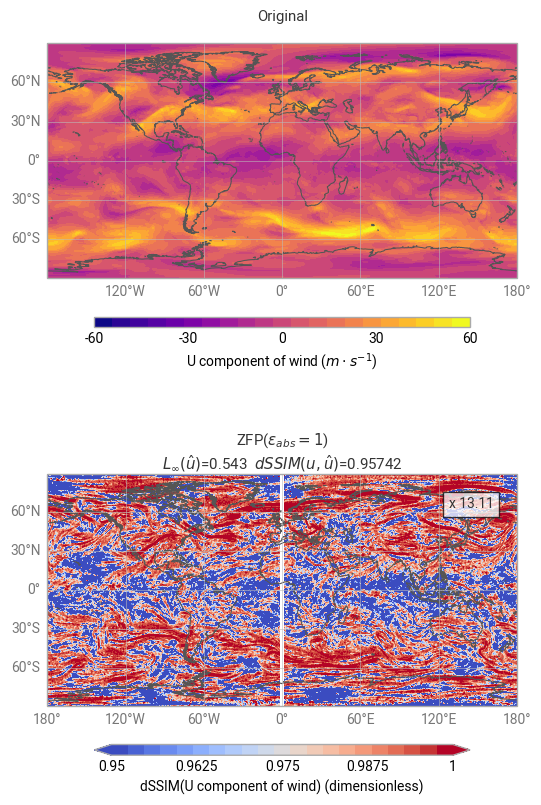

In [23]:
fig = earthkit.plots.Figure(
    size=(10, 15),
    rows=4,
    columns=2,
)

plot_u_wind_dssim(ERA5_U, 1.0, fig.add_map(0, 0), "Original", span=(-60, 60))
plot_u_wind_dssim(
    ERA5_U_codec["zfp.rs"][eb_abs[0]],
    ERA5_U_codec_cr["zfp.rs"][eb_abs[0]],
    fig.add_map(1, 0),
    r"ZFP($\epsilon_{{abs}}=1$)",
    span=(0.95, 1.0),
    error=True,
)
# plot_u_wind_dssim(
#     ERA5_U_codec["sz3.rs"][eb_abs[0]],
#     ERA5_U_codec_cr["sz3.rs"][eb_abs[0]],
#     fig.add_map(2, 0),
#     r"SZ3($\epsilon_{{abs}}=1$)",
#     span=1.0,
#     error=True,
# )
# plot_u_wind_dssim(
#     ERA5_U_codec["sperr.rs"][eb_abs[0]],
#     ERA5_U_codec_cr["sperr.rs"][eb_abs[0]],
#     fig.add_map(3, 0),
#     r"SPERR($\epsilon_{{abs}}=1$)",
#     span=1.0,
#     error=True,
# )

# plot_u_wind_dssim(
#     ERA5_U_codec["zfp.rs"][eb_abs[1]],
#     ERA5_U_codec_cr["zfp.rs"][eb_abs[1]],
#     fig.add_map(1, 1),
#     r"ZFP($\epsilon_{{abs}}=0.1$)",
#     span=0.04,
#     error=True,
# )
# plot_u_wind_dssim(
#     ERA5_U_codec["sz3.rs"][eb_abs[1]],
#     ERA5_U_codec_cr["sz3.rs"][eb_abs[1]],
#     fig.add_map(2, 1),
#     r"SZ3($\epsilon_{{abs}}=0.1$)",
#     span=0.1,
#     error=True,
# )
# plot_u_wind_dssim(
#     ERA5_U_codec["sperr.rs"][eb_abs[1]],
#     ERA5_U_codec_cr["sperr.rs"][eb_abs[1]],
#     fig.add_map(3, 1),
#     r"SPERR($\epsilon_{{abs}}=0.1$)",
#     span=0.1,
#     error=True,
# )

# fig.save("dssim-codec.pdf")

In [39]:
d = dssim_mat(ERA5_U.values, ERA5_U_sg["zero"][eb_abs[0]].values)
np.amin(d), np.amax(d)

(np.float32(-0.8208173), np.float32(1.0008618))

In [50]:
from compression_safeguards.utils.bindings import Bindings
d4 = codec_sg.safeguards[-1].evaluate_qoi(ERA5_U_sg["zero"][eb_abs[0]].values, late_bound=Bindings(**{
    "$x": ERA5_U.values,
    "$X": ERA5_U.values,
    "$x_min": np.amin(ERA5_U.values),
    "$x_max": np.amax(ERA5_U.values),
}))
np.amin(d4), np.amax(d4)

(np.float32(0.9999995), np.float32(1.0000005))

In [51]:
np.amin(ERA5_U.values), np.amax(ERA5_U.values)

(np.float32(-32.55287), np.float32(58.802597))

In [52]:
np.amin(ERA5_U_sg["zero"][eb_abs[0]].values), np.amax(ERA5_U_sg["zero"][eb_abs[0]].values)

(np.float32(-32.55287), np.float32(58.802597))

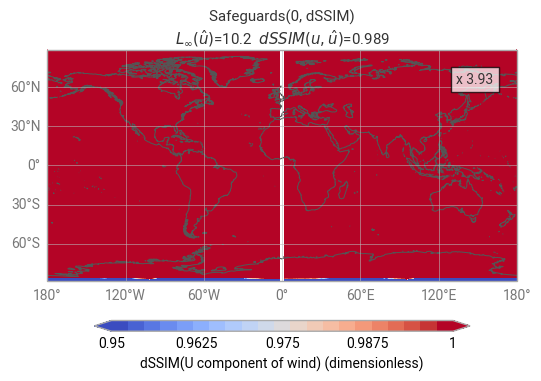

In [22]:
fig = earthkit.plots.Figure(
    size=(10, 15),
    rows=4,
    columns=2,
)

plot_u_wind_dssim(
    ERA5_U_sg["zero"][eb_abs[0]],
    ERA5_U_sg_cr["zero"][eb_abs[0]],
    fig.add_map(0, 0),
    r"Safeguards(0, dSSIM)",
    span=(0.95, 1.0),
    error=True,
)
# plot_u_wind_dssim(
#     ERA5_U_sg["zfp.rs"][eb_abs[0]],
#     ERA5_U_sg_cr["zfp.rs"][eb_abs[0]],
#     fig.add_map(1, 0),
#     r"Safeguards(ZFP($\epsilon_{{abs}}=1$), dSSIM)",
#     span=0.05,
#     error=True,
# )
# plot_u_wind_dssim(
#     ERA5_U_sg["sz3.rs"][eb_abs[0]],
#     ERA5_U_sg_cr["sz3.rs"][eb_abs[0]],
#     fig.add_map(2, 0),
#     r"Safeguards(SZ3($\epsilon_{{abs}}=1$), dSSIM)",
#     span=0.05,
#     error=True,
# )
# plot_u_wind_dssim(
#     ERA5_U_sg["sperr.rs"][eb_abs[0]],
#     ERA5_U_sg_cr["sperr.rs"][eb_abs[0]],
#     fig.add_map(3, 0),
#     r"Safeguards(SPERR($\epsilon_{{abs}}=1$), dSSIM)",
#     span=0.05,
#     error=True,
# )

# plot_u_wind_dssim(
#     ERA5_U_sg["zfp.rs"][eb_abs[1]],
#     ERA5_U_sg_cr["zfp.rs"][eb_abs[1]],
#     fig.add_map(1, 1),
#     r"Safeguards(ZFP($\epsilon_{{abs}}=0.1$), dSSIM)",
#     span=0.025,
#     error=True,
# )
# plot_u_wind_dssim(
#     ERA5_U_sg["sz3.rs"][eb_abs[1]],
#     ERA5_U_sg_cr["sz3.rs"][eb_abs[1]],
#     fig.add_map(2, 1),
#     r"Safeguards(SZ3($\epsilon_{{abs}}=0.1$), dSSIM)",
#     span=0.05,
#     error=True,
# )
# plot_u_wind_dssim(
#     ERA5_U_sg["sperr.rs"][eb_abs[1]],
#     ERA5_U_sg_cr["sperr.rs"][eb_abs[1]],
#     fig.add_map(3, 1),
#     r"Safeguards(SPERR($\epsilon_{{abs}}=0.1$), dSSIM)",
#     span=0.05,
#     error=True,
# )

# fig.save("dssim-sg.pdf")

In [86]:
import scipy as sp

def foo(
    a1: np.ndarray,
    a2: np.ndarray,
    eps: float = 1e-8,
    kernel_size: int = 11,
) -> np.ndarray:
    assert kernel_size % 2 == 1, "kernel_size must be an odd number."

    # re-scale  to [0,1] - if not constant
    smin = min(np.nanmin(a1), np.nanmin(a2))
    smax = max(np.nanmax(a1), np.nanmax(a2))
    r = smax - smin
    if r == 0.0:  # scale by smax if field is a constant (and smax != 0)
        if smax == 0.0:
            sc_a1 = a1
            sc_a2 = a2
        else:
            sc_a1 = a1 / smax
            sc_a2 = a2 / smax
    else:
        sc_a1 = (a1 - smin) * (1/r) # / r
        sc_a2 = (a2 - smin) * (1/r) # / r

    # now quantize to 256 bins
    sc_a1 = np.round(sc_a1 * 255) * (a1.dtype.type(1)/255) # / 255
    sc_a2 = np.round(sc_a2 * 255) * (a1.dtype.type(1)/255) # / 255

    # return sc_a2

    # gaussian filter
    # kernel = Gaussian2DKernel(x_stddev=1.5, x_size=kernel_size, y_size=kernel_size)

    i = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
    k = 1/(np.sqrt(2*np.pi)*1.5) * np.exp((-i**2) / (2*1.5**2))
    kern = np.array([k]).T @ np.array([k])
    kernel = (kern / np.sum(kern)).astype(a2.dtype)
    
    # filter_args = {"boundary": "fill", "preserve_nan": True}

    # convolve = sp.ndimage.convolve
    filter_args = dict(mode="constant", cval=0)

    def convolve(a, k, **kwargs):
        ap = np.pad(a, 5, mode="constant", constant_values=0)
        av = np.lib.stride_tricks.as_strided(ap, a.shape + k.shape, ap.strides + ap.strides)
        ag = (av * k.reshape((1, 1, 11, 11))).reshape(a.shape + (-1,))
        acc = ag[..., 0]
        for i in range(1, ag.shape[-1]):
            acc += ag[..., i]
        return acc
        

    a1_mu = convolve(sc_a1, kernel, **filter_args)
    a2_mu = convolve(sc_a2, kernel, **filter_args)

    # return a2_mu

    a1a1 = convolve(sc_a1 * sc_a1, kernel, **filter_args)
    a2a2 = convolve(sc_a2 * sc_a2, kernel, **filter_args)

    a1a2 = convolve(sc_a1 * sc_a2, kernel, **filter_args)

    ###########
    var_a1 = a1a1 - a1_mu * a1_mu
    var_a2 = a2a2 - a2_mu * a2_mu
    cov_a1a2 = a1a2 - a1_mu * a2_mu

    # return cov_a1a2

    # ssim constants
    C1 = a1.dtype.type(eps)
    C2 = a2.dtype.type(eps)

    ssim_t1 = 2 * a1_mu * a2_mu + C1
    ssim_t2 = 2 * cov_a1a2 + C2

    ssim_b1 = a1_mu * a1_mu + a2_mu * a2_mu + C1
    ssim_b2 = var_a1 + var_a2 + C2

    ssim_1 = ssim_t1 * np.power(ssim_b1, -a1.dtype.type(1))  # / ssim_b1
    ssim_2 = ssim_t2 * np.power(ssim_b2, -a1.dtype.type(1))  # / ssim_b2
    ssim_mat = ssim_1 * ssim_2

    # Cropping the border region of the 2D field where the convolution kernel is not
    # fully overlapping with the 2D input field.
    k = (kernel_size - 1) // 2
    return ssim_mat[k : ssim_mat.shape[0] - k, k : ssim_mat.shape[1] - k]

In [87]:
from compression_safeguards.safeguards.stencil.qoi.eb import StencilQuantityOfInterestErrorBoundSafeguard
from compression_safeguards.utils.bindings import Bindings

def bar(
    a1: np.ndarray,
    a2: np.ndarray,
    eps: float = 1e-8,
    kernel_size: int = 11,
):
    assert kernel_size % 2 == 1, "kernel_size must be an odd number."

    dssim_bound = 0.995
    
    sg = StencilQuantityOfInterestErrorBoundSafeguard(
        qoi="""
        let(
            # dssim constants
            V["sigma"], 1.5,
            V["C1"], 1e-8,
            V["C2"], 1e-8,
        )
        
        (let(
            # we guarantee that
            #  min(data) = min(corrected) and
            #  max(data) = max(corrected)
            # with the sign safeguards above
            V["smin"], c["$x_min"],
            V["smax"], c["$x_max"],
        )(let(
            V["r"], V["smax"] - V["smin"],
        )
        
        (let(
            # re-scale to [0-1] and quantize to 256 bins
            # FIXME: /255 introduces rounding error since QoI folds that into the kernel
            V["sc_a1"], identity(round_ties_even((C["$X"] - V["smin"]) / V["r"] * 255) / 255),
            V["sc_a2"], identity(round_ties_even((X - V["smin"]) / V["r"] * 255) / 255),
        )

        (let(
            # create a 2D 11x11 Gaussian kernel
            V["i"], A[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5],
        )(let(
            V["k"], 1/(sqrt(2*pi)*V["sigma"]) * exp((-V["i"]**2) / (2*V["sigma"]**2)),
        )(let(
            V["kern"], matmul(tr(A[V["k"]]), A[V["k"]]),
        )(let(
            V["kernel"], identity(V["kern"] / asum(V["kern"])),
        )

        (let(
            # apply the Gaussian filter via convolution
            V["a1_mu"], identity(asum(V["sc_a1"] * V["kernel"])),
            V["a2_mu"], identity(asum(V["sc_a2"] * V["kernel"])),
            V["a1a1"], identity(asum(V["sc_a1"]**2 * V["kernel"])),
            V["a2a2"], identity(asum(V["sc_a2"]**2 * V["kernel"])),
            V["a1a2"], identity(asum(identity(V["sc_a1"] * V["sc_a2"]) * V["kernel"])),
        )

        (let(
            ###########
            V["var_a1"], identity(V["a1a1"] - V["a1_mu"]**2),
            V["var_a2"], identity(V["a2a2"] - V["a2_mu"]**2),
            V["cov_a1a2"], identity(V["a1a2"] - V["a1_mu"] * V["a2_mu"]),
        )

        (let(
            # compute the SSIM components
            V["ssim_t1"], identity(2 * V["a1_mu"] * V["a2_mu"] + V["C1"]),
            V["ssim_t2"], identity(2 * V["cov_a1a2"] + V["C2"]),
            V["ssim_b1"], identity(identity(V["a1_mu"]**2 + V["a2_mu"]**2) + V["C1"]),
            V["ssim_b2"], identity(identity(V["var_a1"] + V["var_a2"]) + V["C2"]),
        )

        (let(
            V["ssim_1"], identity(V["ssim_t1"] / V["ssim_b1"]),
            V["ssim_2"], identity(V["ssim_t2"] / V["ssim_b2"]),
        )
        
        (
            # compute the pointwise dSSIM
            V["ssim_1"] * V["ssim_2"]
        ))))))))))))
        # """,
        type="abs",
        eb=1 - dssim_bound,
        # 11x11 neighbourhood
        neighbourhood=[
            # latitude
            # need to use $x_min instead of 0 so that it becomes 0 after linear quantisation
            dict(axis=0, before=5, after=5, boundary="valid"), #"constant", constant_boundary="$x_min"),
            # longitude
            dict(axis=1, before=5, after=5, boundary="valid"), #"constant", constant_boundary="$x_min"),
        ],
    )

    # print(sg._qoi_expr)

    return sg.evaluate_qoi(a2, late_bound=Bindings(**{
        "$x": a1,
        "$X": a1,
        "$x_min": min(np.amin(a1), np.amin(a2)),
        "$x_max": max(np.amax(a1), np.amax(a2)),
    })).astype(a2.dtype)

In [88]:
from matplotlib import pyplot as plt

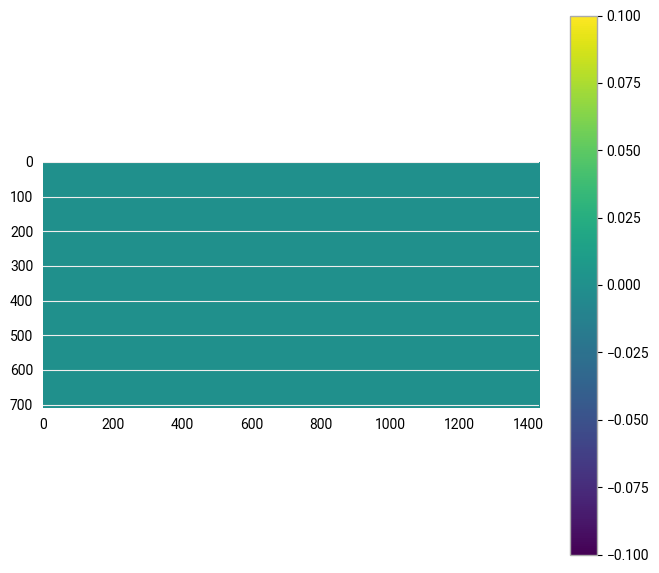

In [89]:
r = foo(ERA5_U.values, ERA5_U_codec["zfp.rs"][eb_abs[0]].values) - bar(ERA5_U.values, ERA5_U_codec["zfp.rs"][eb_abs[0]].values)
plt.imshow(r)
plt.colorbar()
plt.show()

In [90]:
np.amin(r), np.amax(r)

(np.float32(0.0), np.float32(0.0))

In [19]:
i = np.array([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
k = 1/(np.sqrt(2*np.pi)*1.5) * np.exp((-i**2) / (2*1.5**2))
kern = np.array([k]).T @ np.array([k])
(kern / np.sum(kern)).astype(np.float32)

array([[1.0575656e-06, 7.8144112e-06, 3.7022477e-05, 1.1246435e-04,
        2.1905065e-04, 2.7356116e-04, 2.1905065e-04, 1.1246435e-04,
        3.7022477e-05, 7.8144112e-06, 1.0575656e-06],
       [7.8144112e-06, 5.7741127e-05, 2.7356116e-04, 8.3100545e-04,
        1.6185775e-03, 2.0213588e-03, 1.6185775e-03, 8.3100545e-04,
        2.7356116e-04, 5.7741127e-05, 7.8144112e-06],
       [3.7022477e-05, 2.7356116e-04, 1.2960556e-03, 3.9370693e-03,
        7.6683639e-03, 9.5766271e-03, 7.6683639e-03, 3.9370693e-03,
        1.2960556e-03, 2.7356116e-04, 3.7022477e-05],
       [1.1246435e-04, 8.3100545e-04, 3.9370693e-03, 1.1959760e-02,
        2.3294432e-02, 2.9091226e-02, 2.3294432e-02, 1.1959760e-02,
        3.9370693e-03, 8.3100545e-04, 1.1246435e-04],
       [2.1905065e-04, 1.6185775e-03, 7.6683639e-03, 2.3294432e-02,
        4.5371357e-02, 5.6661971e-02, 4.5371357e-02, 2.3294432e-02,
        7.6683639e-03, 1.6185775e-03, 2.1905065e-04],
       [2.7356116e-04, 2.0213588e-03, 9.5766271e-0

In [20]:
e = StencilQuantityOfInterestErrorBoundSafeguard(
    qoi="""
    let(
        # dssim constants
        V["sigma"], 1.5,
        V["C1"], 1e-8,
        V["C2"], 1e-8,
    )
    
    (let(
        # we guarantee that
        #  min(data) = min(corrected) and
        #  max(data) = max(corrected)
        # with the sign safeguards above
        V["smin"], c["$x_min"],
        V["smax"], c["$x_max"],
    )(let(
        V["r"], V["smax"] - V["smin"],
    )
    
    (let(
        # re-scale to [0-1] and quantize to 256 bins
        V["sc_a1"], identity(round_ties_even((C["$X"] - V["smin"]) / V["r"] * 255) / 255),
        V["sc_a2"], identity(round_ties_even((X - V["smin"]) / V["r"] * 255) / 255),
    )

    (let(
        # create a 2D 11x11 Gaussian kernel
        V["i"], A[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5],
    )(let(
        V["k"], 1/(sqrt(2*pi)*V["sigma"]) * exp((-V["i"]**2) / (2*V["sigma"]**2)),
    )(let(
        V["kern"], matmul(tr(A[V["k"]]), A[V["k"]]),
    )(let(
        V["kernel"], V["kern"] / asum(V["kern"]),
    )

    (let(
        # apply the Gaussian filter via convolution
        V["a1_mu"], asum(V["sc_a1"] * V["kernel"]),
        V["a2_mu"], asum(V["sc_a2"] * V["kernel"]),
        V["a1a1"], asum(V["sc_a1"]**2 * V["kernel"]),
        V["a2a2"], asum(V["sc_a2"]**2 * V["kernel"]),
        V["a1a2"], asum(V["sc_a1"] * V["sc_a2"] * V["kernel"]),
    )

    (let(
        ###########
        V["var_a1"], V["a1a1"] - V["a1_mu"]**2,
        V["var_a2"], V["a2a2"] - V["a2_mu"]**2,
        V["cov_a1a2"], V["a1a2"] - V["a1_mu"] * V["a2_mu"],
    )

    (let(
        # compute the SSIM components
        V["ssim_t1"], 2 * V["a1_mu"] * V["a2_mu"] + V["C1"],
        V["ssim_t2"], 2 * V["cov_a1a2"] + V["C2"],
        V["ssim_b1"], V["a1_mu"]**2 + V["a2_mu"]**2 + V["C1"],
        V["ssim_b2"], V["var_a1"] + V["var_a2"] + V["C2"],
    )

    (let(
        V["ssim_1"], V["ssim_t1"] / V["ssim_b1"],
        V["ssim_2"], V["ssim_t2"] / V["ssim_b2"],
    )
    
    (
        # compute the pointwise dSSIM
        # V["ssim_1"] * V["ssim_2"]
        V["a2_mu"]
    ))))))))))))
    # """,
    type="abs",
    eb=1 - 0.995,
    # 11x11 neighbourhood
    neighbourhood=[
        # latitude
        dict(axis=0, before=5, after=5, boundary="constant", constant_boundary=0),
        # longitude
        dict(axis=1, before=5, after=5, boundary="constant", constant_boundary=0),
    ],
)._qoi_expr

float 1.05756559815326e-6 1.05756559815326e-06
float 7.81441153305360e-6 7.8144115330536e-06
float 3.70224770827489e-5 3.70224770827489e-05
float 0.000112464355116679 0.000112464355116679
float 0.000219050652866017 0.000219050652866017
float 0.000273561160085806 0.000273561160085806
float 0.000219050652866017 0.000219050652866017
float 0.000112464355116679 0.000112464355116679
float 3.70224770827489e-5 3.70224770827489e-05
float 7.81441153305360e-6 7.8144115330536e-06
float 1.05756559815326e-6 1.05756559815326e-06
float 7.81441153305360e-6 7.8144115330536e-06
float 5.77411251978637e-5 5.77411251978637e-05
float 0.000273561160085806 0.000273561160085806
float 0.000831005429087200 0.0008310054290872
float 0.00161857756253439 0.00161857756253439
float 0.00202135875836257 0.00202135875836257
float 0.00161857756253439 0.00161857756253439
float 0.000831005429087200 0.0008310054290872
float 0.000273561160085806 0.000273561160085806
float 5.77411251978637e-5 5.77411251978637e-05
float 7.814411

In [21]:
import re

In [22]:
np.array([np.float32(x) for x in re.findall(r"\d+\.\d+(?:e-\d+)?", str(e))]).reshape(11, 11)

array([[1.0575656e-06, 7.8144112e-06, 3.7022477e-05, 1.1246435e-04,
        2.1905065e-04, 2.7356116e-04, 2.1905065e-04, 1.1246435e-04,
        3.7022477e-05, 7.8144112e-06, 1.0575656e-06],
       [7.8144112e-06, 5.7741127e-05, 2.7356116e-04, 8.3100545e-04,
        1.6185775e-03, 2.0213588e-03, 1.6185775e-03, 8.3100545e-04,
        2.7356116e-04, 5.7741127e-05, 7.8144112e-06],
       [3.7022477e-05, 2.7356116e-04, 1.2960556e-03, 3.9370693e-03,
        7.6683639e-03, 9.5766271e-03, 7.6683639e-03, 3.9370693e-03,
        1.2960556e-03, 2.7356116e-04, 3.7022477e-05],
       [1.1246435e-04, 8.3100545e-04, 3.9370693e-03, 1.1959760e-02,
        2.3294432e-02, 2.9091226e-02, 2.3294432e-02, 1.1959760e-02,
        3.9370693e-03, 8.3100545e-04, 1.1246435e-04],
       [2.1905065e-04, 1.6185775e-03, 7.6683639e-03, 2.3294432e-02,
        4.5371357e-02, 5.6661971e-02, 4.5371357e-02, 2.3294432e-02,
        7.6683639e-03, 1.6185775e-03, 2.1905065e-04],
       [2.7356116e-04, 2.0213588e-03, 9.5766271e-0

In [23]:
str(e)

'NonAssociativeMul(identity(NonAssociativeMul(round_ties_even(NonAssociativeMul(NonAssociativeAdd(X[0, 0], -c["$x_min"][5, 5]), 255/(c["$x_max"][5, 5] - c["$x_min"][5, 5]))), 1/255)), 1.05756559815326e-6) + NonAssociativeMul(identity(NonAssociativeMul(round_ties_even(NonAssociativeMul(NonAssociativeAdd(X[0, 1], -c["$x_min"][5, 5]), 255/(c["$x_max"][5, 5] - c["$x_min"][5, 5]))), 1/255)), 7.8144115330536e-6) + NonAssociativeMul(identity(NonAssociativeMul(round_ties_even(NonAssociativeMul(NonAssociativeAdd(X[0, 2], -c["$x_min"][5, 5]), 255/(c["$x_max"][5, 5] - c["$x_min"][5, 5]))), 1/255)), 3.70224770827489e-5) + NonAssociativeMul(identity(NonAssociativeMul(round_ties_even(NonAssociativeMul(NonAssociativeAdd(X[0, 3], -c["$x_min"][5, 5]), 255/(c["$x_max"][5, 5] - c["$x_min"][5, 5]))), 1/255)), 0.000112464355116679) + NonAssociativeMul(identity(NonAssociativeMul(round_ties_even(NonAssociativeMul(NonAssociativeAdd(X[0, 4], -c["$x_min"][5, 5]), 255/(c["$x_max"][5, 5] - c["$x_min"][5, 5]))), 1

In [40]:
np.array(Gaussian2DKernel(x_stddev=1.5, x_size=11, y_size=11), dtype=np.float32)

array([[1.0575656e-06, 7.8144112e-06, 3.7022477e-05, 1.1246435e-04,
        2.1905065e-04, 2.7356116e-04, 2.1905065e-04, 1.1246435e-04,
        3.7022477e-05, 7.8144112e-06, 1.0575656e-06],
       [7.8144112e-06, 5.7741127e-05, 2.7356116e-04, 8.3100545e-04,
        1.6185775e-03, 2.0213588e-03, 1.6185775e-03, 8.3100545e-04,
        2.7356116e-04, 5.7741127e-05, 7.8144112e-06],
       [3.7022477e-05, 2.7356116e-04, 1.2960556e-03, 3.9370693e-03,
        7.6683639e-03, 9.5766271e-03, 7.6683639e-03, 3.9370693e-03,
        1.2960556e-03, 2.7356116e-04, 3.7022477e-05],
       [1.1246435e-04, 8.3100545e-04, 3.9370693e-03, 1.1959760e-02,
        2.3294432e-02, 2.9091226e-02, 2.3294432e-02, 1.1959760e-02,
        3.9370693e-03, 8.3100545e-04, 1.1246435e-04],
       [2.1905065e-04, 1.6185775e-03, 7.6683639e-03, 2.3294432e-02,
        4.5371357e-02, 5.6661971e-02, 4.5371357e-02, 2.3294432e-02,
        7.6683639e-03, 1.6185775e-03, 2.1905065e-04],
       [2.7356116e-04, 2.0213588e-03, 9.5766271e-0

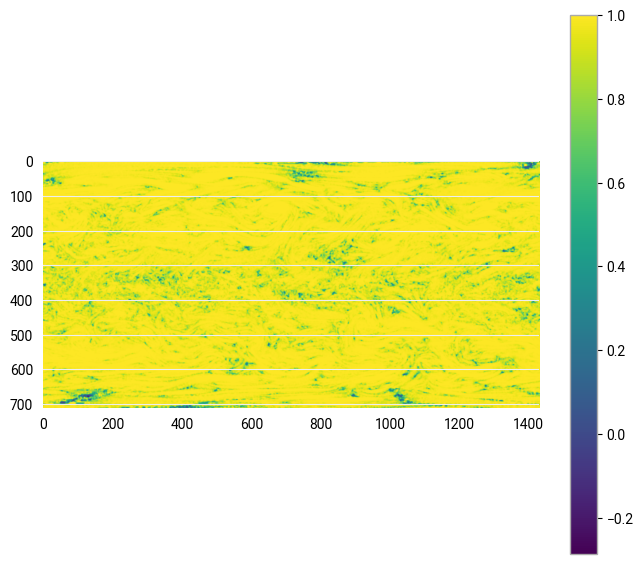

In [102]:
x1 = foo(ERA5_U.values.astype(float), ERA5_U_codec["zfp.rs"][eb_abs[0]].values.astype(float))
plt.imshow(x1)
plt.colorbar()
plt.show()

In [103]:
np.nanmean(x1)

np.float64(0.9574463197946101)

In [104]:
np.mean(np.abs(x1) > 1)

np.float64(0.0)

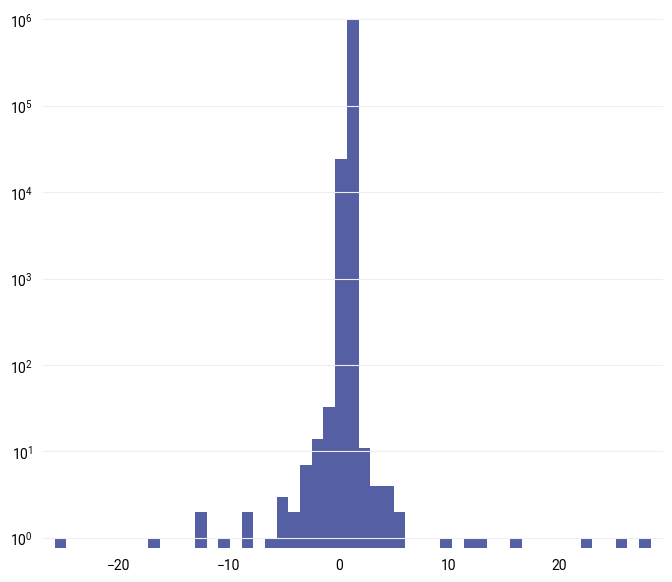

In [99]:
plt.hist(x1.flatten(), bins=51, log=True)
plt.show()

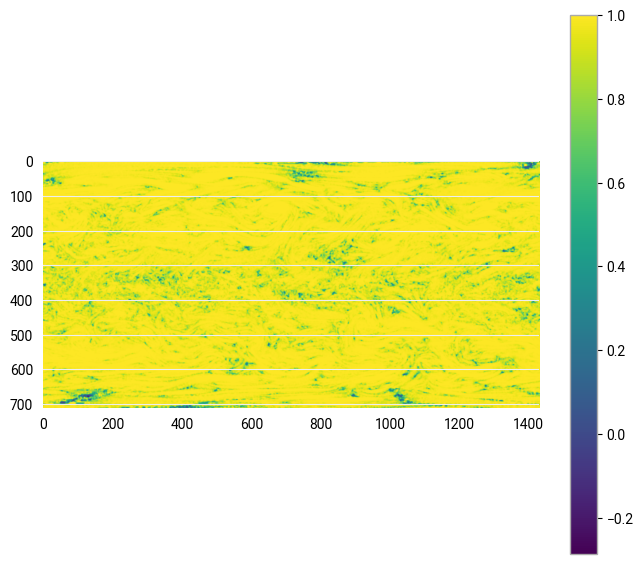

In [105]:
x2 = bar(ERA5_U.values.astype(float), ERA5_U_codec["zfp.rs"][eb_abs[0]].values.astype(float))
plt.imshow(x2)
plt.colorbar()
plt.show()

In [106]:
np.nanmean(x2)

np.float64(0.957446319794529)

In [107]:
np.mean(np.abs(x2) > 1)

np.float64(0.0)

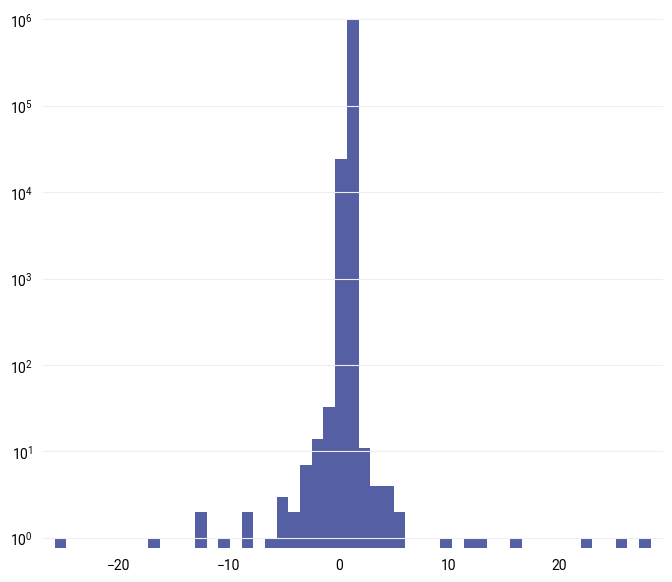

In [100]:
plt.hist(x2.flatten(), bins=51, log=True)
plt.show()

In [43]:
a1 = ERA5_U.values
a2 = ERA5_U_codec["zfp.rs"][eb_abs[0]].values

s_min = min(np.nanmin(a1), np.nanmin(a2))
s_max = max(np.nanmax(a1), np.nanmax(a2))

sc_a2 = np.round((a2 - s_min) / (s_max - s_min) * 255)

In [46]:
convolve(sc_a2, (kern / np.sum(kern)).astype(sc_a2.dtype), boundary="fill")[7][:10]

array([ 73.72644,  98.53528, 111.27256, 115.46558, 116.35062, 116.47039,
       116.47039, 116.47039, 116.47039, 116.47039], dtype=float32)

In [61]:
np.pad(sc_a2, 5, mode="constant", constant_values=0)[7][:10]

array([  0.,   0.,   0.,   0.,   0., 115., 115., 115., 115., 115.],
      dtype=float32)

In [51]:
import scipy as sp

In [54]:
sp.signal.convolve2d(np.pad(sc_a2, 5, mode="constant", constant_values=0), (kern / np.sum(kern)).astype(sc_a2.dtype), mode="valid", boundary="fill", fillvalue=0)

array([[ 42.075523,  56.225063,  63.465504, ...,  63.135044,  55.91133 ,
         41.83508 ],
       [ 58.343468,  77.9689  ,  88.02559 , ...,  87.59919 ,  77.58181 ,
         58.05125 ],
       [ 67.92191 ,  90.77392 , 102.49658 , ..., 102.00929 ,  90.35191 ,
         67.60872 ],
       ...,
       [ 61.27561 ,  81.894485,  92.47989 , ...,  92.587616,  81.925705,
         61.281643],
       [ 53.95212 ,  72.106895,  81.42778 , ...,  81.51854 ,  72.1332  ,
         53.957203],
       [ 39.721703,  53.087997,  59.950478, ...,  60.00567 ,  53.103992,
         39.724796]], shape=(721, 1440), dtype=float32)

In [57]:
from compression_safeguards.safeguards.stencil import _pad_with_boundary, BoundaryCondition

In [63]:
y1 = _pad_with_boundary(
    sc_a2,
    BoundaryCondition.constant,
    5,
    5,
    constant=0,
    axis=0,
)
y2 = _pad_with_boundary(
    y1,
    BoundaryCondition.constant,
    5,
    5,
    constant=0,
    axis=1,
)
y2[7][:10]

array([  0.,   0.,   0.,   0.,   0., 115., 115., 115., 115., 115.],
      dtype=float32)

In [65]:
np.all(y2 == np.pad(sc_a2, 5, mode="constant", constant_values=0))

np.True_